# Evalution of aerodynamics corfficients and moments

In [56]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Model parameters

In [57]:
Chord_Length = 0.390 # m
Span  = 0.551  # m
Planform_area = 0.1074 # m2
MR_point_distance = 0.21 # m
g = 9.81 # m/s2
rho = 1.225 # kg/m3

## Inverse calibration coefficient matrix

In [58]:
cali_matrix = pd.read_csv('Aerodynamics_Experiment_3_Data/Inverse_Calibration_Coeff_Matrix.dat',delimiter='\t',header=None)
cali_matrix

,0,1,2,3,4,5
0,6.722423,0.068790,-0.193090,-0.044077,0.082625,0.143804
1,0.224755,14.005905,-0.298689,0.370984,-0.025113,0.499237
2,-0.133373,0.107297,15.505331,0.002459,0.765804,0.050340
3,-0.079169,0.064270,0.009651,4.475195,-0.073766,-0.212330
4,0.047195,0.003390,-0.097551,0.040600,5.145576,0.324017
5,0.023096,3.150696,-3.952312,0.597108,0.662367,449.361481


## Force and Moment(coefficients) calculation

### The forces and moments are evaluated at the balance center using equations given below
> $$ 
 A_{xbc} = A_x \quad\quad R_{mbc} = R_m\\
 S_{bc} = S_1 + S_2 \quad\quad M_{pbc} = (N_1-N_2)*d\\
 N_{bc} = N_1 + N_2 \quad\quad M_{ybc} = (S_1-S_2)*d
$$

In [105]:
def F_and_M_at_balance_center(df,cali_matrix = cali_matrix,d=0.035):
    volt_data = np.array(df[['Ax (volt)','N1 (volt)','N2 (volt)','S1 (volt)','S2 (volt)','Rm (volt)']]).transpose()
    cali_coeff_mat = np.array(cali_matrix)
    volt_to_Kg = np.matmul(cali_coeff_mat,volt_data)
    # print(f"{volt_to_Kg[:,17] = }")
    Kg_to_N = g*volt_to_Kg[:5,:]
    # print(f"{Kg_to_N[:,17] = }")
    Kg_to_Nm = g*volt_to_Kg[-1,:]*pow(10,-3)
    # print(f"{Kg_to_Nm[17] = }")
    Ax_bc = Kg_to_N[0,:]
    S_bc = Kg_to_N[3,:] + Kg_to_N[4,:]
    N_bc = Kg_to_N[1,:] + Kg_to_N[2,:]
    R_mbc = Kg_to_Nm
    Mp_bc = (Kg_to_N[1,:] - Kg_to_N[2,:])*d
    My_bc = (Kg_to_N[3,:] - Kg_to_N[4,:])*d
    F_bc = np.array([-Ax_bc,S_bc,-N_bc]).reshape((3,27))
    M_bc = np.array([R_mbc,Mp_bc,My_bc]).reshape((3,27))
    return F_bc,M_bc

### From the balance center, transformation is done to body or model axes, aligning theforce arms of the two axes using following equation
> $$ \overline{F_B} = T_b^{B}\overline{F_b}\\
     \overline{M_B} = T_b^{B}\overline{M_b}
$$

In [106]:
def Body_force_and_moments_about_reference(Fbc,Mbc):
    # Transformation matrix from balance center to reference point
    TbB = np.identity(3)
    F_B = np.matmul(TbB,Fbc)
    F_B[0,:] = -F_B[0,:]
    F_B[2,:] = -F_B[2,:]
    # reference point
    dx = 0.21 # m
    dy = 0
    dz = 0
    Mx_B = Mbc[0,:] - (dy*Fbc[2,:] - dz*Fbc[1,:])
    My_B = Mbc[1,:] - (dz*Fbc[0,:] - dx*Fbc[2,:])
    Mz_B = Mbc[2,:] - (dx*Fbc[1,:] - dy*Fbc[1,:])
    M_B = np.array([Mx_B,My_B,Mz_B]).reshape((3,27))
    return F_B,M_B

In [107]:
def Wind_Axis_force_and_moments_about_reference(FB,MB,AoA):
    F_w = np.zeros((3,len(AoA)))
    M_w = np.zeros((3,len(AoA)))
    # Transformation matrix from body to Wind axis

    for i in range(len(AoA)):
        TBW = np.array([np.cos(AoA[i]*0.0175), 0, -np.sin(AoA[i]*0.0175),
        0, 1, 0,
        np.sin(AoA[i]*0.0175), 0, np.cos(AoA[i]*0.0175)]).reshape((3,3))
        F_w[:,i] = np.matmul(TBW.transpose(),FB[:,i])
        M_w[:,i] = np.matmul(TBW.transpose(),MB[:,i])

    F_w[0,:] = -F_w[0,:]
    F_w[2,:] = -F_w[2,:]
    # print(f"{F_w[:,17]}\n{M_w[:,17]}")
    return F_w,M_w

In [111]:
def Coeff_force_and_moments(F,M,q):
    C_D= -F[0,:]/q/Planform_area
    C_S= F[1,:]/q/Planform_area
    C_L= -F[2,:]/q/Planform_area
    C_F = np.array([C_D,C_S,C_L]).reshape(3,27)
    C_l= M[0,:]/q/Planform_area/Span
    C_m= M[1,:]/q/Planform_area/Chord_Length
    C_n= M[2,:]/q/Planform_area/Span
    C_M = np.array([C_l,C_m,C_n]).reshape((3,27))
    return C_F,C_M

## 15 m/s data

In [63]:
WindData_15mps = pd.read_csv('Aerodynamics_Experiment_3_Data/Data/WindData_15mps.dat',delimiter='\t',header=None)
WindData_15mps.rename(columns={0:'Dynamic Pressure(N/m2)',1:'AoA (degree)',2:'Ax (volt)',3:'N1 (volt)',\
                          4:'N2 (volt)',5:'S1 (volt)',6:'S2 (volt)',7:'Rm (volt)'},inplace = True)                 
WindData_15mps

,Dynamic Pressure(N/m2),AoA (degree),Ax (volt),N1 (volt),N2 (volt),S1 (volt),S2 (volt),Rm (volt)
0,134.171310,-6.008682,0.001795,-0.014398,-0.023495,-0.003953,-0.000465,0.004388
1,134.171310,-5.002186,0.002349,-0.012135,-0.020281,-0.003782,-0.000510,0.006127
2,134.171310,-4.000437,0.002946,-0.010131,-0.016638,-0.003415,-0.000527,0.007387
3,134.171310,-2.999813,0.003525,-0.007847,-0.013561,-0.003009,-0.000770,0.007670
4,134.735055,-1.998876,0.004060,-0.005679,-0.010464,-0.002730,-0.000907,0.008069
5,134.171310,-0.999813,0.004355,-0.003667,-0.007523,-0.002671,-0.000721,0.008858
6,134.171310,0.000687,0.004466,-0.001988,-0.003585,-0.002682,-0.000495,0.010580
7,135.298800,1.001686,0.004472,-0.001103,0.003194,-0.002525,-0.000117,0.011370
8,135.298800,2.000250,0.004105,-0.000352,0.009304,-0.002472,0.000225,0.010581
9,136.426290,3.000125,0.004038,0.000025,0.016570,-0.002670,0.000900,0.012103


In [112]:
F_b, M_b= F_and_M_at_balance_center(WindData_15mps)
F_B,M_B = Body_force_and_moments_about_reference(Fbc=F_b,Mbc=M_b)
C_FB, C_MB = Coeff_force_and_moments(F = F_B,M=M_B,q=np.array(WindData_15mps['Dynamic Pressure(N/m2)']))
F_w,M_w = Wind_Axis_force_and_moments_about_reference(FB = F_B,MB = M_B,AoA = np.array(WindData_15mps['AoA (degree)']))
C_Fw,C_Mw = Coeff_force_and_moments(F=F_w,M= M_w,q= np.array(WindData_15mps['Dynamic Pressure(N/m2)']))


In [110]:
aoa = np.array(WindData_15mps['AoA (degree)'])

Text(0, 0.5, 'Cm_n')

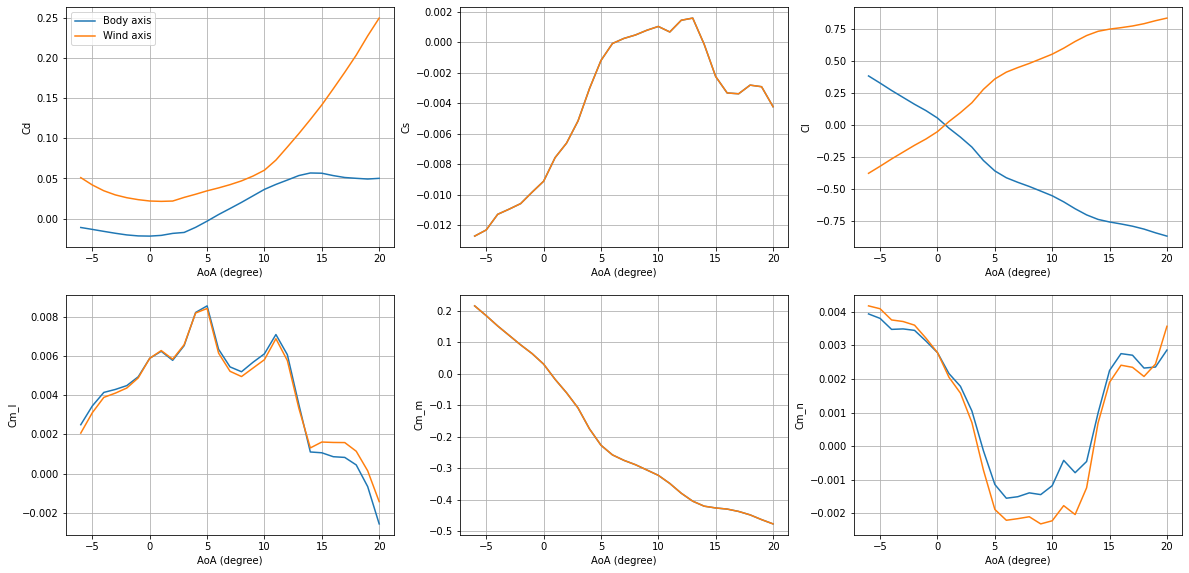

In [66]:

plt.figure(figsize=(20,15));
plt.subplot(331);
plt.plot(aoa, C_FB[0])
plt.plot(aoa, C_Fw[0]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cd');plt.legend(['Body axis','Wind axis']);
plt.subplot(332);
plt.plot(aoa, C_FB[1])
plt.plot(aoa, C_Fw[1]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cs');
plt.subplot(333);
plt.plot(aoa, C_FB[2])
plt.plot(aoa, C_Fw[2]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cl');
plt.subplot(334);
plt.plot(aoa, C_MB[0])
plt.plot(aoa, C_Mw[0]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cm_l');
plt.subplot(335);
plt.plot(aoa, C_MB[1])
plt.plot(aoa, C_Mw[1]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cm_m');
plt.subplot(336);
plt.plot(aoa, C_MB[2])
plt.plot(aoa, C_Mw[2]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cm_n');


## 30 m/s data

In [67]:
WindData_30mps = pd.read_csv('Aerodynamics_Experiment_3_Data/Data/WindData_30mps.dat',delimiter='\t',header=None)
WindData_30mps.rename(columns={0:'Dynamic Pressure(N/m2)',1:'AoA (degree)',2:'Ax (volt)',3:'N1 (volt)',\
                          4:'N2 (volt)',5:'S1 (volt)',6:'S2 (volt)',7:'Rm (volt)'},inplace = True)
WindData_30mps.drop([27,28,29],inplace=True)
WindData_30mps

,Dynamic Pressure(N/m2),AoA (degree),Ax (volt),N1 (volt),N2 (volt),S1 (volt),S2 (volt),Rm (volt)
0,529.920300,-6.005247,0.000073,-0.063104,-0.070328,-0.004294,-0.002375,0.034596
1,528.792810,-5.000312,0.003099,-0.057927,-0.050334,-0.004018,-0.001635,0.041724
2,529.920300,-3.999063,0.005882,-0.051842,-0.033022,-0.003458,-0.001114,0.044434
3,530.371296,-2.998251,0.008609,-0.046044,-0.016190,-0.002140,-0.001653,0.048484
4,529.920300,-1.997814,0.010789,-0.039946,0.000162,-0.001019,-0.001715,0.051636
5,530.935041,-0.998001,0.012227,-0.033923,0.017362,-0.000761,-0.000558,0.052839
6,529.920300,0.001562,0.012375,-0.027808,0.033357,-0.001119,0.000930,0.052242
7,529.920300,0.999938,0.011696,-0.022055,0.050594,-0.000771,0.001647,0.055847
8,529.469304,2.000999,0.010637,-0.019269,0.074162,0.000372,0.002183,0.060673
9,529.356555,3.001124,0.008220,-0.017436,0.100775,-0.000222,0.004577,0.059385


In [68]:
WindData_30mps['Dynamic Pressure(N/m2)'] = pd.Series(WindData_30mps['Dynamic Pressure(N/m2)'],dtype=np.float64)

In [69]:
F_b30, M_b30= F_and_M_at_balance_center(WindData_30mps)
F_B30,M_B30 = Body_force_and_moments_about_reference(Fbc=F_b30,Mbc=M_b30)
C_FB30, C_MB30 = Coeff_force_and_moments(F = F_B30,M=M_B30,q=np.array(WindData_30mps['Dynamic Pressure(N/m2)']))
F_w30,M_w30 = Wind_Axis_force_and_moments_about_reference(FB = F_B30,MB = M_B30,AoA = np.array(WindData_30mps['AoA (degree)']))
C_Fw30,C_Mw30 = Coeff_force_and_moments(F=F_w30,M= M_w30,q= np.array(WindData_30mps['Dynamic Pressure(N/m2)']))


In [70]:
aoa30 = np.array(WindData_30mps['AoA (degree)'])

Text(0, 0.5, 'Cm_n')

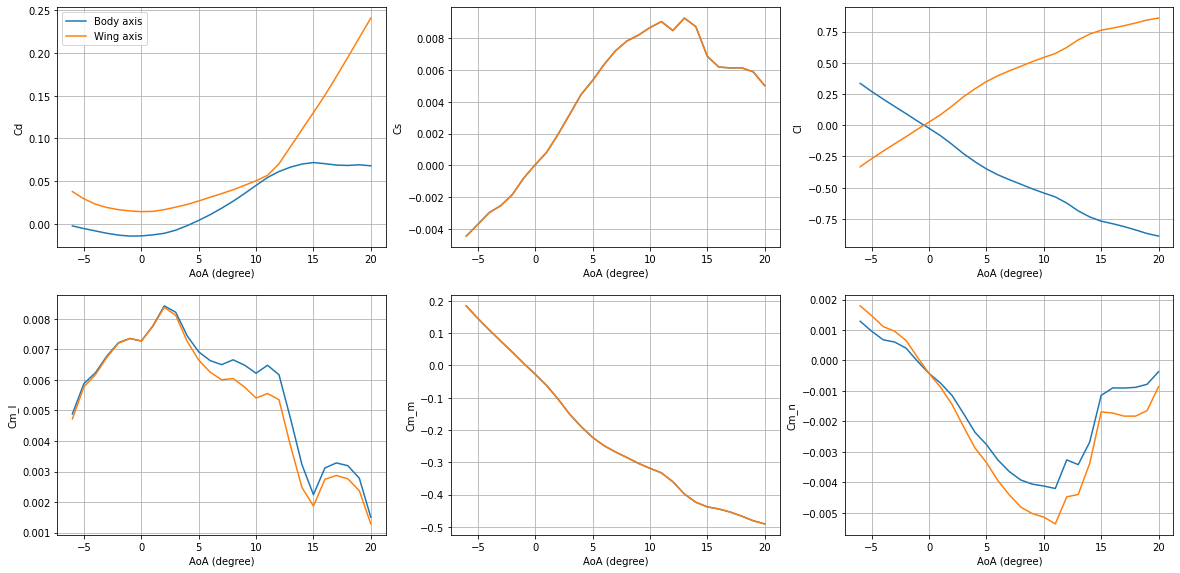

In [71]:

plt.figure(figsize=(20,15));
plt.subplot(331);
plt.plot(aoa30, C_FB30[0])
plt.plot(aoa30, C_Fw30[0]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cd');plt.legend(['Body axis','Wind axis']);
plt.subplot(332);
plt.plot(aoa30, C_FB30[1])
plt.plot(aoa30, C_Fw30[1]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cs');
plt.subplot(333);
plt.plot(aoa30, C_FB30[2])
plt.plot(aoa30, C_Fw30[2]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cl');
plt.subplot(334);
plt.plot(aoa30, C_MB30[0])
plt.plot(aoa30, C_Mw30[0]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cm_l');
plt.subplot(335);
plt.plot(aoa30, C_MB30[1])
plt.plot(aoa30, C_Mw30[1]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cm_m');
plt.subplot(336);
plt.plot(aoa30, C_MB30[2])
plt.plot(aoa30, C_Mw30[2]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cm_n');


# Wing axis coefficients at different velocities

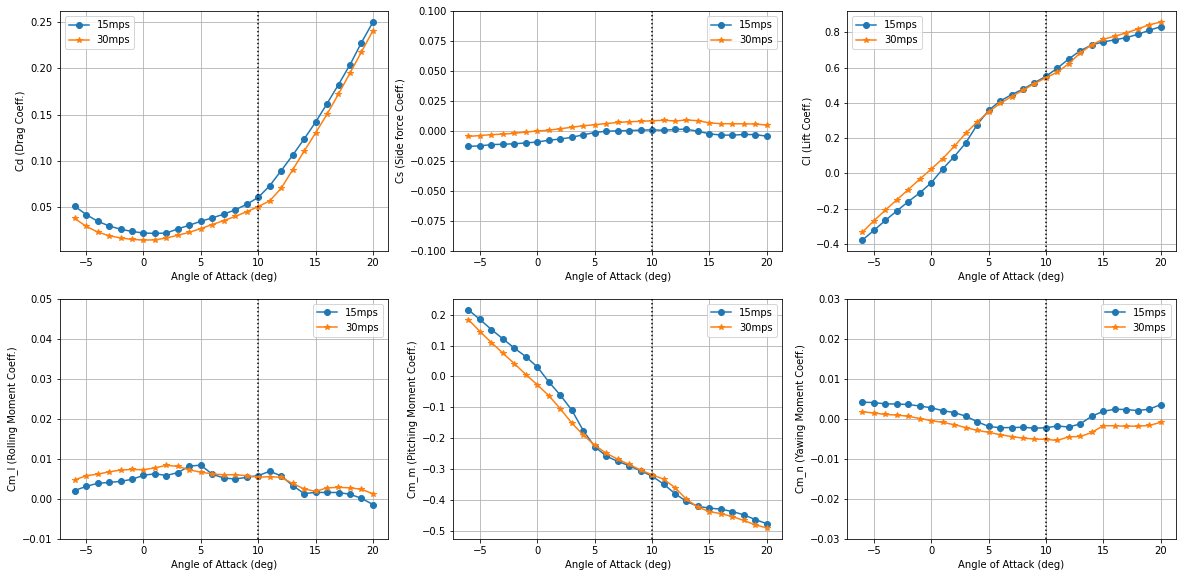

In [88]:

plt.figure(figsize=(20,15));
plt.subplot(331);
plt.plot(aoa, C_Fw[0],'-o')
plt.plot(aoa30, C_Fw30[0],'-*');plt.grid();plt.xlabel('Angle of Attack (deg)');plt.ylabel('Cd (Drag Coeff.)');plt.legend(['15mps','30mps']);plt.axvline(x=10,color ='k',linestyle=':');
plt.subplot(332);
plt.plot(aoa, C_Fw[1],'-o')
plt.plot(aoa30, C_Fw30[1],'-*');plt.grid();plt.xlabel('Angle of Attack (deg)');plt.ylabel('Cs (Side force Coeff.)');plt.legend(['15mps','30mps']);plt.ylim((-0.1,0.1));plt.axvline(x=10,color ='k',linestyle=':');
plt.subplot(333);
plt.plot(aoa, C_Fw[2],'-o')
plt.plot(aoa30, C_Fw30[2],'-*');plt.grid();plt.xlabel('Angle of Attack (deg)');plt.ylabel('Cl (Lift Coeff.)');plt.legend(['15mps','30mps']);plt.axvline(x=10,color ='k',linestyle=':');
plt.subplot(334);
plt.plot(aoa, C_Mw[0],'-o')
plt.plot(aoa30, C_Mw30[0],'-*');plt.grid();plt.xlabel('Angle of Attack (deg)');plt.ylabel('Cm_l (Rolling Moment Coeff.)');plt.ylim((-0.01,0.05));plt.legend(['15mps','30mps']);plt.axvline(x=10,color ='k',linestyle=':');
plt.subplot(335);
plt.plot(aoa, C_Mw[1],'-o')
plt.plot(aoa30, C_Mw30[1],'-*');plt.grid();plt.xlabel('Angle of Attack (deg)');plt.ylabel('Cm_m (Pitching Moment Coeff.)');plt.legend(['15mps','30mps']);plt.axvline(x=10,color ='k',linestyle=':');
plt.subplot(336);
plt.plot(aoa, C_Mw[2],'-o')
plt.plot(aoa30, C_Mw30[2],'-*');plt.grid();plt.xlabel('Angle of Attack (deg)');plt.ylabel('Cm_n (Yawing Moment Coeff.)');plt.legend(['15mps','30mps']);plt.ylim((-0.03,0.03));plt.axvline(x=10,color ='k',linestyle=':');


# Body axis coefficients at different velocities

Text(0, 0.5, 'Cm_n')

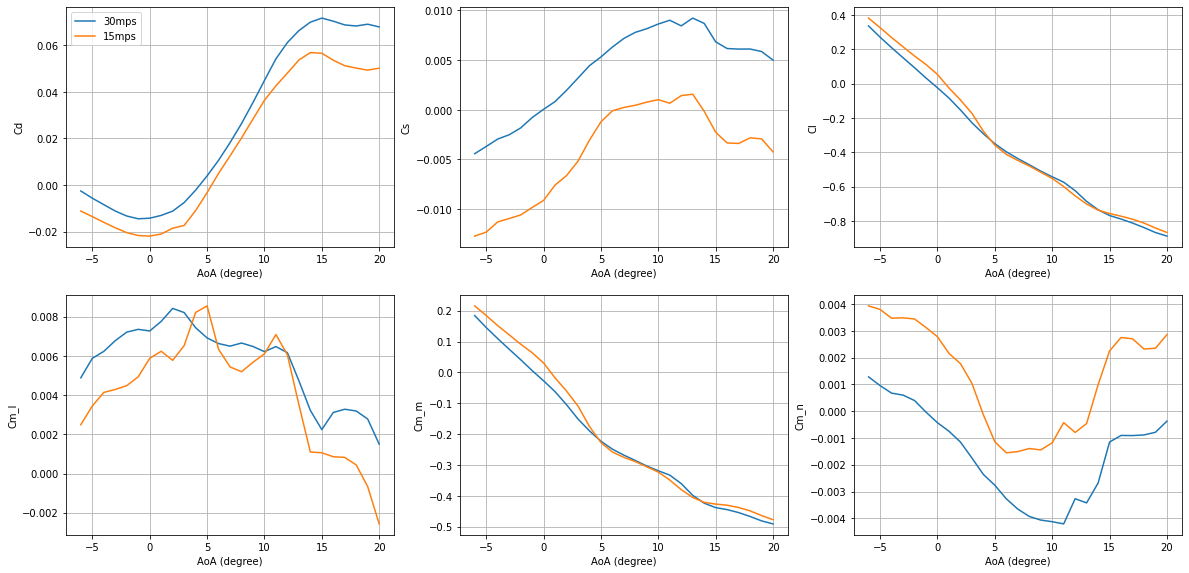

In [73]:

plt.figure(figsize=(20,15));
plt.subplot(331);
plt.plot(aoa30, C_FB30[0])
plt.plot(aoa, C_FB[0]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cd');plt.legend(['30mps','15mps']);
plt.subplot(332);
plt.plot(aoa30, C_FB30[1])
plt.plot(aoa, C_FB[1]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cs');
plt.subplot(333);
plt.plot(aoa30, C_FB30[2])
plt.plot(aoa, C_FB[2]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cl');
plt.subplot(334);
plt.plot(aoa30, C_MB30[0])
plt.plot(aoa, C_MB[0]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cm_l');
plt.subplot(335);
plt.plot(aoa30, C_MB30[1])
plt.plot(aoa, C_MB[1]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cm_m');
plt.subplot(336);
plt.plot(aoa30, C_MB30[2])
plt.plot(aoa, C_MB[2]);plt.grid();plt.xlabel('AoA (degree)');plt.ylabel('Cm_n');
